<a href="https://colab.research.google.com/github/justinsydnor/GB894/blob/main/ModelSelectionAndFairness_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of Accuracy-Fairness Comparisons

For this notebook we want to create a simulated dataset and use it to illustrate how different model specifications can lead to different tradeoffs in accuracy and fairness.

## Features of the simulation
For this simulation I will create a data set with the following properties:


*   There is a variable called **group** that denotes our protected class identities (e.g., race, gender, age).
*   **group** in this case is directly predictive given other things we know.
*   There is a variable called **x** that is strongly correlated with the outcome but also **negatively correlated with group**.
*   There is a variable called **z** that is a **"redundant encoding"** for **group** in that it is a) not itself predictive of the outcome when conditional on other information and b) is strongly correlated with **group**


## Point of what the simulation shows.
The key point of the simulation is that there can be cases of **Pareto Improvements** where some models improve on both fairness and accuracy. In fact, we show that the unblinded "group-aware" model can actually be more accurate and more fair!



## Data construction
The code below simulates data with these properties

In [1]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Number of observations
n = 10000

# Generate group variable: first half 0, second half 1
group = np.array([0] * (n // 2) + [1] * (n // 2))

# Generate x: normal with mean 0.5 for group 0, mean -0.5 for group 1, std 1
# Generate both potential arrays of x values with size n
x_group_0 = np.random.normal(loc=0.5, scale=1.0, size=n)
x_group_1 = np.random.normal(loc=-0.5, scale=1.0, size=n)

# Use np.where to select from the full size arrays based on the group condition
x = np.where(group == 0,
             x_group_0,  # Select from this array when group is 0
             x_group_1)  # Select from this array when group is 1

# Generate e: standard normal, independent of group; this is the error in the outcome process
e = np.random.normal(loc=0.0, scale=1.0, size=n)

# Generate z: indicator 90% correlated with group
# We flip group with 10% chance to get z
flip = np.random.binomial(n=1, p=0.1, size=n)
z = np.abs(group - flip)

# Create DataFrame
df = pd.DataFrame({
    'group': group,
    'x': x,
    'e': e,
    'z': z
})

# Optional: check correlation between z and group
correlation = np.corrcoef(df['z'], df['group'])[0, 1]
print(f"Correlation between z and group: {correlation:.3f}")

# Show first few rows
print(df.head())

Correlation between z and group: 0.795
   group         x         e  z
0      0  0.996714  0.348286  0
1      0  0.361736  0.283324  0
2      0  1.147689 -0.936520  0
3      0  2.023030  0.579584  0
4      0  0.265847 -1.490083  0


The next chunk of code creates our outcome. This is our data generating process. We assume that y is formed strongly based on x -- namely (2*x) -- and has a level shift in the group and then some random error.

Note that z does not enter the data generating process.

In [3]:
# Now generate a variable called y that is y = 2*x + group + .5*e

y = 2 * df['x'] + df['group'] + 0.5 * df['e']
df['y'] = y

print(df.head())

   group         x         e  z         y
0      0  0.996714  0.348286  0  2.167571
1      0  0.361736  0.283324  0  0.865133
2      0  1.147689 -0.936520  0  1.827117
3      0  2.023030  0.579584  0  4.335852
4      0  0.265847 -1.490083  0 -0.213348


## Analysis if we received the data
Now suppose that we got this dataset from someone and didn't know how it was created. Let's do a few steps to understand the data.

### Summary statistics
Some basic summary statistics to understand what's in the data.

In [4]:
# Create a summary table to show the minimum, average, and maximum values for each of the variables in the data frame y, x, z, and group

# Select the variables of interest
variables = ['y', 'x', 'z', 'group']
df_subset = df[variables]
# Generate the summary table
summary_table = df_subset.agg(['min', 'mean', 'max'])
summary_table

,y,x,z,group
min,-6.822430,-4.356375,0.0000,0.0
mean,0.515886,0.011059,0.5011,0.5
max,9.709138,4.426238,1.0000,1.0


The above table tells us about the range of the data and we see that y ans x are continuous, while z and group appear to be categorical with averages of right around 50% taking value 1.

### Plot the distributions of the other variables by group
Since we are going to be interested in model fairness as part of our project, it will help to plot the distributions of the other variables by group.

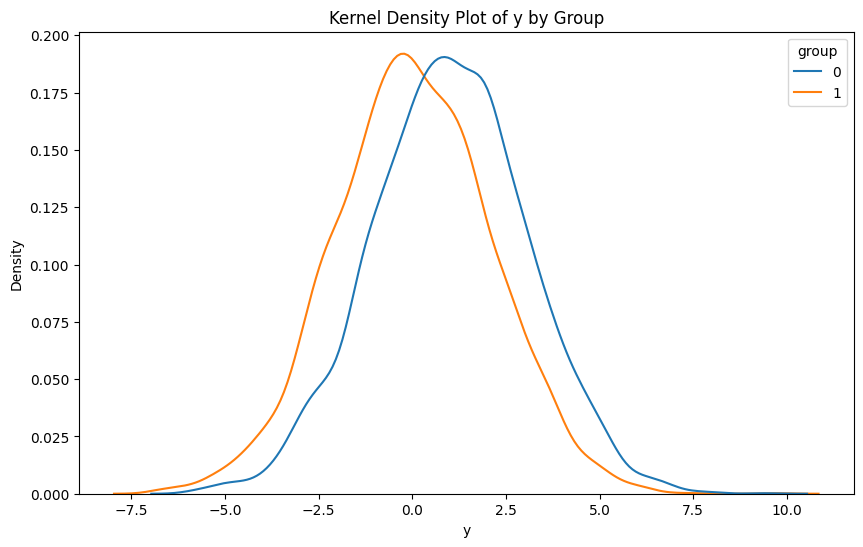

In [5]:
# Show a kernel density plot of y with lines for each group

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='y', hue='group', common_norm=False)
plt.title('Kernel Density Plot of y by Group')
plt.xlabel('y')
plt.ylabel('Density')
plt.show()

We see that the y variable (our outcome) is higher on average in Group 0. The variance of the distributons of y look similar between Group 0 and 1, so Group 0 appears to be mean-shifted over relative to Group 1.

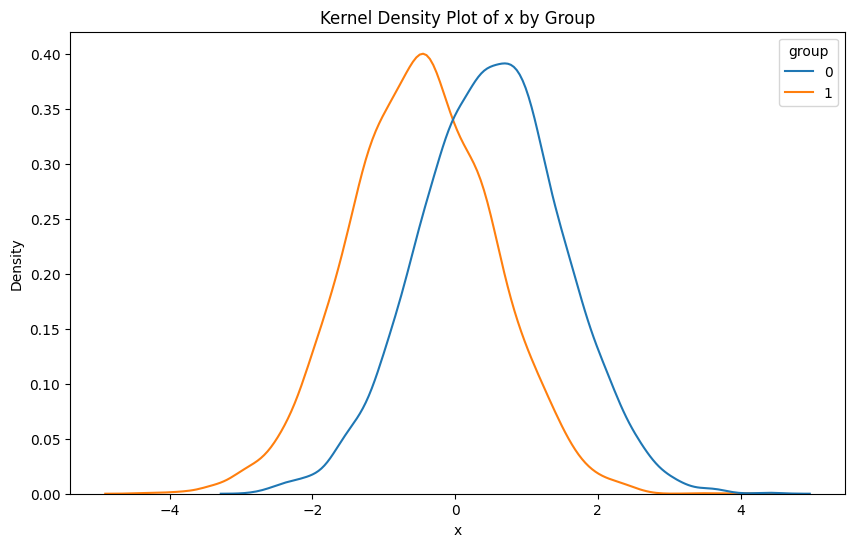

In [6]:
# Show a kernel density plot of x for each group

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='x', hue='group', common_norm=False)
plt.title('Kernel Density Plot of x by Group')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()

We see something very similar when we look at the distribution of x by group. It is higher on average for group 0 than group 1.

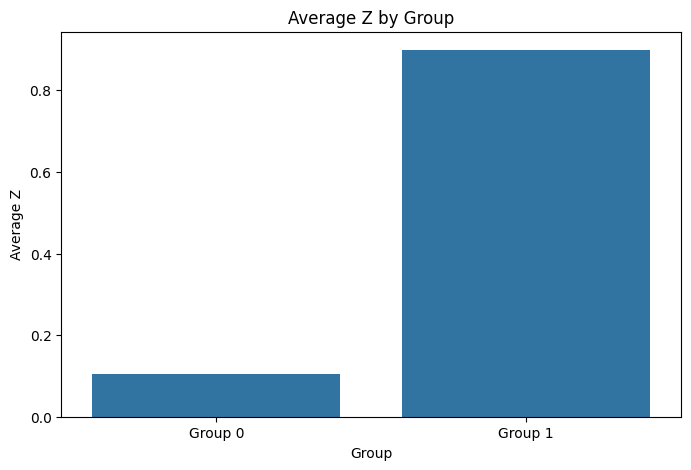

In [7]:
# Show a bar graph of the average z by group

# Calculate the mean of 'z' for each 'group'
average_z_by_group = df.groupby('group')['z'].mean().reset_index()

# Plot the bar graph
plt.figure(figsize=(8, 5))
sns.barplot(x='group', y='z', data=average_z_by_group)
plt.title('Average Z by Group')
plt.xlabel('Group')
plt.ylabel('Average Z')
plt.xticks(ticks=[0, 1], labels=['Group 0', 'Group 1'])
plt.show()

We see that the variable z differs substantially across groups, with Group 0 averaging about 10% and Group 1 averaging about 90% for z.

### How do the features correlate with the outcome by group?
Now that we know that our group correlates with both the outcome and the features we might use to predict, the next step is to understand if the features correlate with the outcome within group.

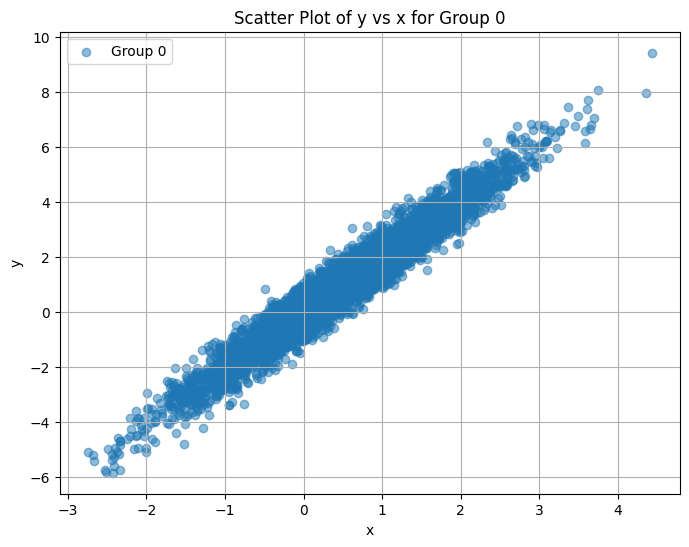

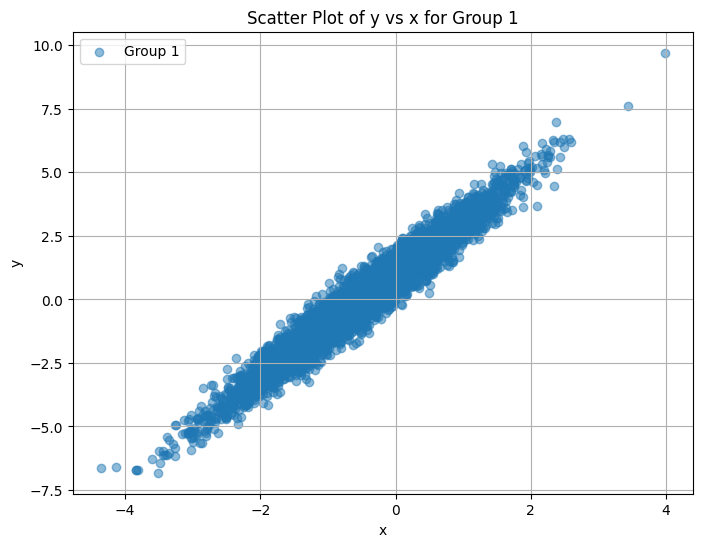

In [8]:
# For each group create a scatter plot of y vs x

# Group the DataFrame by the 'group' column
grouped = df.groupby('group')

# Iterate through each group and create a scatter plot
for name, group_df in grouped:
    plt.figure(figsize=(8, 6))
    plt.scatter(group_df['x'], group_df['y'], alpha=0.5, label=f'Group {name}')
    plt.title(f'Scatter Plot of y vs x for Group {name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

So what we see here is that x is possitively correlated with the outcome in each of the groups. We can also learn something important by noticing the level of the outcome y for the different groups. Take a look at the spot on the x-axis where x = 0. In group 0 this is associated with an average y (middle of the scatter) of just about exactly y = 0. For group 1 if we look at x=0 we instead see that y is between 0 and 2.5 and eyeballing looks to be about 1.

**Important observation**: We saw above the Group 0 has higher average y values than Group 1. However, we are now seeing that for the same value of x (i.e., condtional on x) the average y value is higher in Group 1 not Group 0. So this tells us that the correlation between x and group status pushes the average y value for the group to be potentially misleading. This will lead to some important results below.

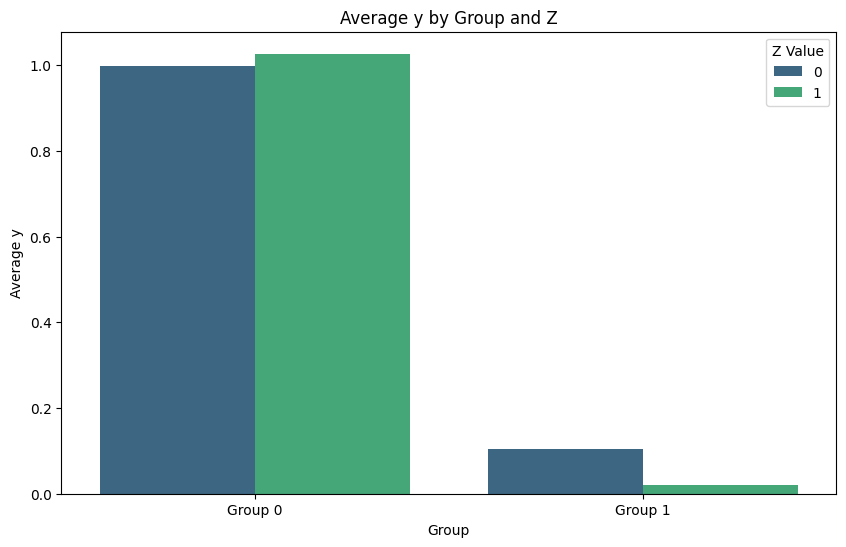

In [ ]:
# prompt: For each group show the average y by values of z in a bar graph

# Calculate the average of 'y' for each combination of 'group' and 'z'
average_y_by_group_z = df.groupby(['group', 'z'])['y'].mean().reset_index()

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='y', hue='z', data=average_y_by_group_z, palette='viridis')
plt.title('Average y by Group and Z')
plt.xlabel('Group')
plt.ylabel('Average y')
plt.xticks(ticks=[0, 1], labels=['Group 0', 'Group 1'])
plt.legend(title='Z Value')
plt.show()

Ok so here we see that the average y  value does not differ much by z within group.

### Create different model specifications

Here I will run a series of simple ordinary least squares regressions. Since I have two potential predictors **x** and **z**, I will create three models:


*   blind: regress y on x and z
*   xonly: regress y on x
*   zonly: regress y on z



#### The full blind model
Here I regress y on x and z.

We look at the distribution of the predicted values by Group. We are interested as our primary fairness metric in the difference in the average predicted value by group.

We also report overall accuracy measures. Mean squared error (MSE) is a natural overall model accuracy measure for a regression. However, R-squared is perhaps preferable for interpretation and is simply R-squred = 1 - (MSE)/var(Y). We record and report both





                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 6.267e+04
Date:                Sat, 24 May 2025   Prob (F-statistic):               0.00
Time:                        02:59:12   Log-Likelihood:                -8724.0
No. Observations:               10000   AIC:                         1.745e+04
Df Residuals:                    9997   BIC:                         1.748e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1245      0.009     14.643      0.0

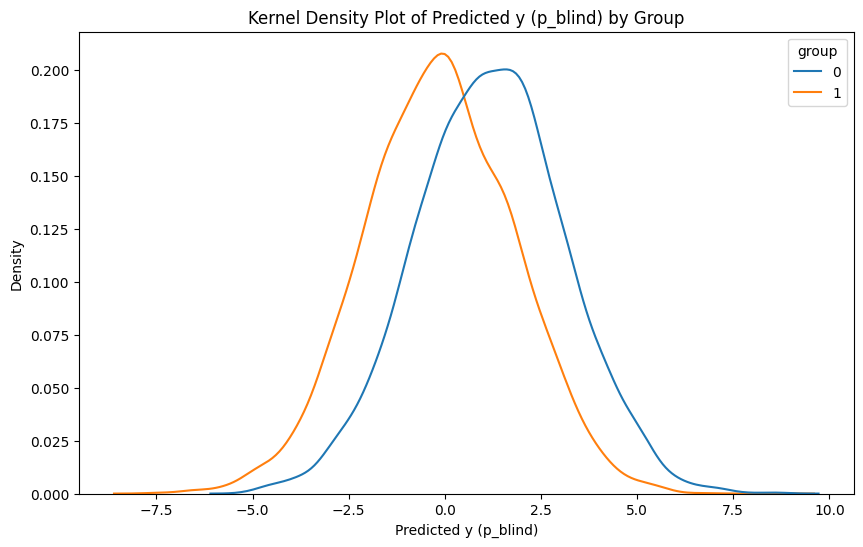

Average predicted difference (Group 1 - Group 0): -1.320
Mean Squared Error (MSE) of the blind model: 0.335
R-squared of the blind model: 0.926


In [9]:
# Regress y on x and z and show the regression coefficients. Record this as model called "reg_blind".
#Generate the predicted values and name them p_blind.
#Show the kernel density of p_blind by group. Create a measure called avgpreddiff_blind that is the difference
#in average predicted value for group 1 minus average predicted value for group 0.
#Calculate the model mean squared error and save it as mse_blind and the R-squared as r2_blind.

import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

# Regress y on x and z
reg_blind = smf.ols(formula='y ~ x + z', data=df).fit()

# Show the regression coefficients
print(reg_blind.summary())

# Generate the predicted values
p_blind = reg_blind.predict(df[['x', 'z']])

# Add predicted values to the DataFrame for easier plotting
df['p_blind'] = p_blind

# Show the kernel density of p_blind by group
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='p_blind', hue='group', common_norm=False)
plt.title('Kernel Density Plot of Predicted y (p_blind) by Group')
plt.xlabel('Predicted y (p_blind)')
plt.ylabel('Density')
plt.show()

# Create a measure called avgpreddiff_blind that is the difference in average predicted value for group 1 minus average predicted value for group 0
avgpreddiff_blind = df[df['group'] == 1]['p_blind'].mean() - df[df['group'] == 0]['p_blind'].mean()
print(f"Average predicted difference (Group 1 - Group 0): {avgpreddiff_blind:.3f}")

# Calculate the model mean squared error
mse_blind = mean_squared_error(df['y'], p_blind)
print(f"Mean Squared Error (MSE) of the blind model: {mse_blind:.3f}")

# Calculate the model R-squared
r2_blind = reg_blind.rsquared
print(f"R-squared of the blind model: {r2_blind:.3f}")

We can see here when we predict y on x and z that both variables get strong weight in the regression. We also see that Group 1 gets averae predicted values that are 1.3 units lower than for Group 0. The R-squared is pretty high at 92.6%.

#### The simpler model of xonly

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 8.983e+04
Date:                Sat, 24 May 2025   Prob (F-statistic):               0.00
Time:                        03:03:48   Log-Likelihood:                -10246.
No. Observations:               10000   AIC:                         2.050e+04
Df Residuals:                    9998   BIC:                         2.051e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4959      0.007     73.541      0.0

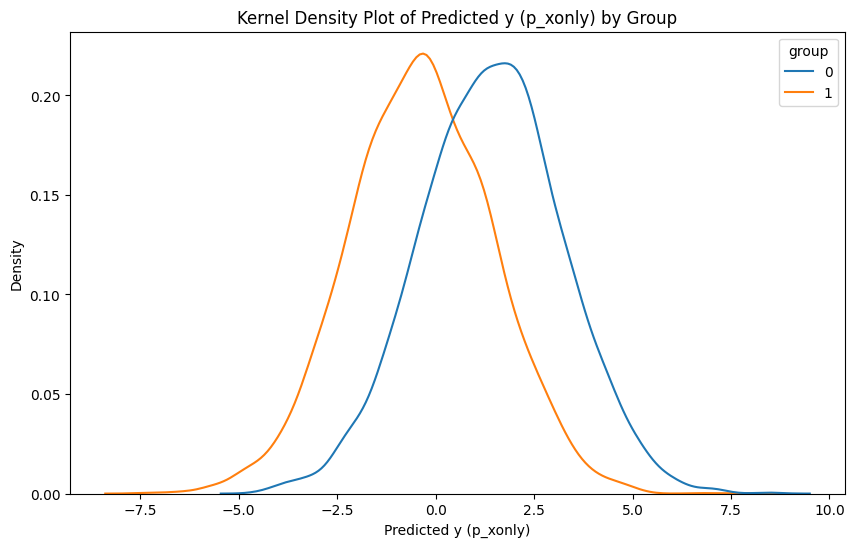

Average predicted difference (Group 1 - Group 0): -1.792
Mean Squared Error (MSE) of the xonly model: 0.454
R-squared of the xonly model: 0.900


In [12]:
# Now the same thing for xonly: y regressed on x alone.

import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
# Regress y on x
reg_xonly = smf.ols(formula='y ~ x', data=df).fit()

# Show the regression coefficients
print(reg_xonly.summary())

# Generate the predicted values
p_xonly = reg_xonly.predict(df[['x']])

# Add predicted values to the DataFrame for easier plotting
df['p_xonly'] = p_xonly

# Show the kernel density of p_xonly by group
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='p_xonly', hue='group', common_norm=False)
plt.title('Kernel Density Plot of Predicted y (p_xonly) by Group')
plt.xlabel('Predicted y (p_xonly)')
plt.ylabel('Density')
plt.show()

# Create a measure called avgpreddiff_xonly that is the difference in average predicted value for group 1 minus average predicted value for group 0
avgpreddiff_xonly = df[df['group'] == 1]['p_xonly'].mean() - df[df['group'] == 0]['p_xonly'].mean()
print(f"Average predicted difference (Group 1 - Group 0): {avgpreddiff_xonly:.3f}")

# Calculate the model mean squared error
mse_xonly = mean_squared_error(df['y'], p_xonly)
print(f"Mean Squared Error (MSE) of the xonly model: {mse_xonly:.3f}")

# Calculate the model R-squared
r2_xonly = reg_xonly.rsquared
print(f"R-squared of the xonly model: {r2_xonly:.3f}")

Overall the predictions for xonly look qualitatively pretty similar to what we saw from the full blind model. Note, though, that the predicted difference is bigger (less fair) **and** that the R-squared dropped to 90% (from 92.6% in the blind model with both x and z). So this is telling us that the simpler model is actually both less accurate (as expected) and less fair (more surprising!)

#### The simpler model of zonly

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     349.4
Date:                Sat, 24 May 2025   Prob (F-statistic):           1.15e-76
Time:                        03:04:17   Log-Likelihood:                -21580.
No. Observations:               10000   AIC:                         4.316e+04
Df Residuals:                    9998   BIC:                         4.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9082      0.030     30.632      0.0

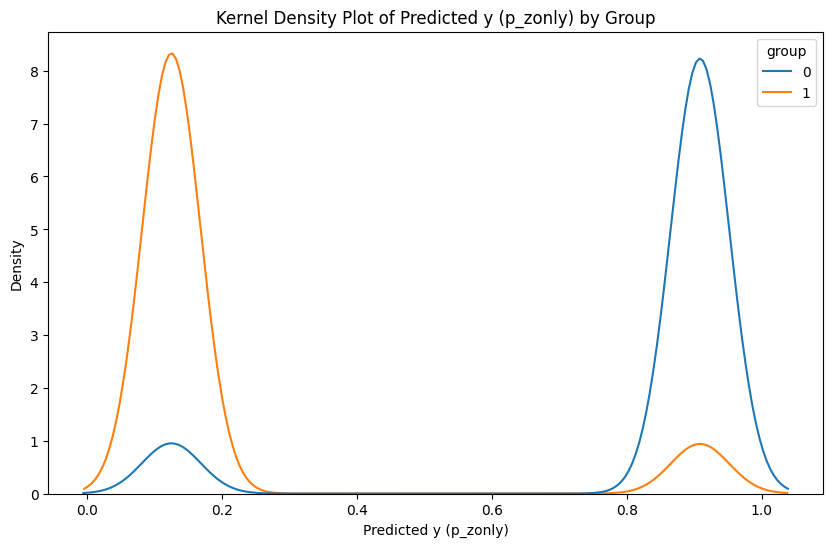

Average predicted difference (Group 1 - Group 0): -0.622
Mean Squared Error (MSE) of the zonly model: 4.385
R-squared of the zonly model: 0.034


In [14]:
# Now for z only
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
# Regress y on z
reg_zonly = smf.ols(formula='y ~ z', data=df).fit()

# Show the regression coefficients
print(reg_zonly.summary())

# Generate the predicted values
p_zonly = reg_zonly.predict(df[['z']])

# Add predicted values to the DataFrame for easier plotting
df['p_zonly'] = p_zonly

# Show the kernel density of p_xonly by group
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='p_zonly', hue='group', common_norm=False)
plt.title('Kernel Density Plot of Predicted y (p_zonly) by Group')
plt.xlabel('Predicted y (p_zonly)')
plt.ylabel('Density')
plt.show()

# Create a measure called avgpreddiff_xonly that is the difference in average predicted value for group 1 minus average predicted value for group 0
avgpreddiff_zonly = df[df['group'] == 1]['p_zonly'].mean() - df[df['group'] == 0]['p_zonly'].mean()
print(f"Average predicted difference (Group 1 - Group 0): {avgpreddiff_zonly:.3f}")

# Calculate the model mean squared error
mse_zonly = mean_squared_error(df['y'], p_zonly)
print(f"Mean Squared Error (MSE) of the zonly model: {mse_zonly:.3f}")

# Calculate the model R-squared
r2_zonly = reg_zonly.rsquared
print(f"R-squared of the zonly model: {r2_zonly:.3f}")

The zonly model is quite different. Now the average predicted difference falls quite a bit (more fair), but the R-squared falls dramatically to only 3.4%.

### Explore the fairness-accuracy tradeoff visually
Now that we have our three models, we can create a graph to look at the fairness-accuracy tradeoffs across models.

I will use R-squared for accuracy, since it naturally is increasing for more accurate models.

For the fairness metric I will use the difference in Group 1 vs. Group 0 predicted average. Since Group 1 has smaller average predictions in these models, this direction will mean that higher values on the x-axis will be "more fair". Exactly how you do this depends on the context of the fairness measure.

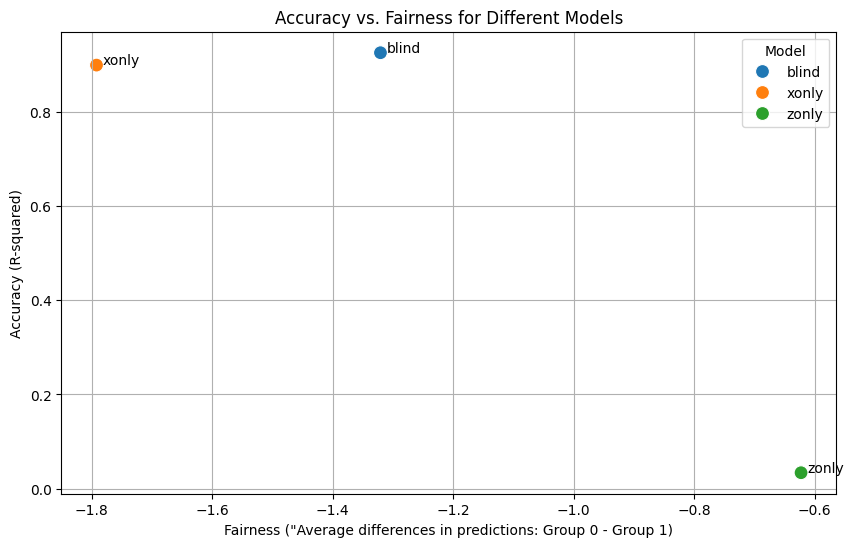

In [ ]:
# For each 'model' in the list "blind, xonly, zonly" plot on the same graph r2_'model' vs -avgepreddiff_'model'.
#Label the y-axis "Accuracy (R-squared)" and the x-axis "Fairness ("Average differences in predictions: Group 0 - Group 1)"

# Prepare data for plotting
models = ['blind', 'xonly', 'zonly']
r2_values = [r2_blind, r2_xonly, r2_zonly]
avgpreddiff_values = [avgpreddiff_blind, avgpreddiff_xonly, avgpreddiff_zonly]

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'model': models,
    'R2': r2_values,
    'Average Prediction Difference (Group 1 - Group 0)': avgpreddiff_values
})

# Plotting
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=plot_df,
    x='Average Prediction Difference (Group 1 - Group 0)',
    y='R2',
    hue='model',
    s=100 # size of markers
)

# Add labels to the points
for i in range(plot_df.shape[0]):
    plt.text(x=plot_df['Average Prediction Difference (Group 1 - Group 0)'][i] + 0.01,
             y=plot_df['R2'][i] + 0.001,
             s=plot_df['model'][i],
             fontdict=dict(color='black', size=10))

plt.title('Accuracy vs. Fairness for Different Models')
plt.xlabel('Fairness ("Average differences in predictions: Group 0 - Group 1)')
plt.ylabel('Accuracy (R-squared)')
plt.grid(True)
plt.legend(title='Model')
plt.show()


This allows us to see visually that the "blind model" that includes x and z is actually both more accurate and more fair than the model with only x. So here, the blind model with both x and z is a **Pareto Improvement** relative to just x. This is true even though we saw above that z is not predictive within group (and we know from simulating the data that z is a **redundant encoding**). Here allowing the model to proxy for group is actually leading to the pareto improvement.  

If we instead used the zonly simple model, we see a further reduction in disparities but at the cost of a big drop in accuracy to almost zero.

It is lilkely in this case that we would choose to use the blind model, since it has dramatically better predictive power than z-only and is a Pareto Improvement on x-only.

### The fully group aware model

We might also be intersted to know what our predictions would look like if we gave our model access to the group variable. Even if we would never deploy such a model, exploring it allows us to have a sense of how different our chosen models are to ones that are fully group aware.

Here we just add the group indicator to our linear regression and then again plot our graph of accuracy vs. fairness.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 5.826e+04
Date:                Sat, 24 May 2025   Prob (F-statistic):               0.00
Time:                        03:11:35   Log-Likelihood:                -7166.6
No. Observations:               10000   AIC:                         1.434e+04
Df Residuals:                    9996   BIC:                         1.437e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0150      0.008     -1.970      0.0

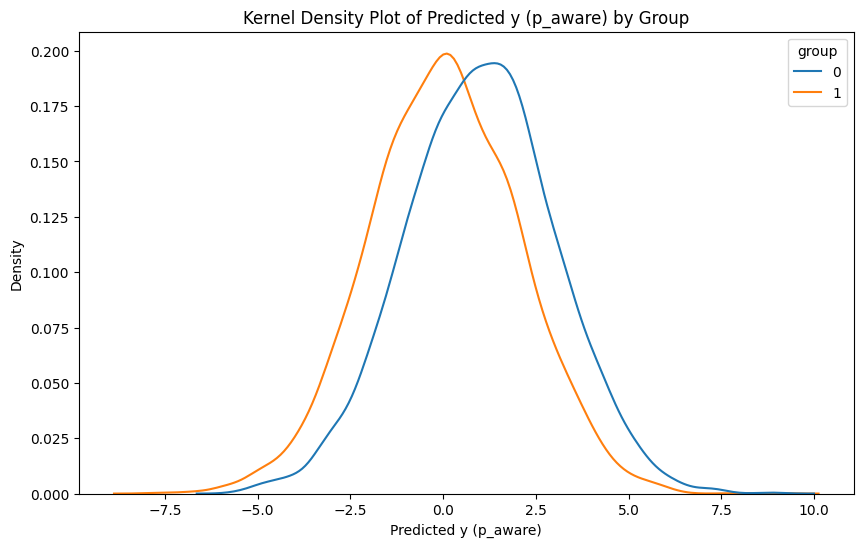

Average predicted difference (Group 1 - Group 0): -0.972
Mean Squared Error (MSE) of the aware model: 0.245
R-squared of the aware model: 0.946


In [15]:
# Now for the fully group aware model
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

# Regress y on x, z, and group
reg_aware = smf.ols(formula='y ~ x+z+group', data=df).fit()

# Show the regression coefficients
print(reg_aware.summary())

# Generate the predicted values
p_aware = reg_aware.predict(df[['z']])

# Add predicted values to the DataFrame for easier plotting
df['p_aware'] = p_aware

# Show the kernel density of p_aware by group
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='p_aware', hue='group', common_norm=False)
plt.title('Kernel Density Plot of Predicted y (p_aware) by Group')
plt.xlabel('Predicted y (p_aware)')
plt.ylabel('Density')
plt.show()

# Create a measure called avgpreddiff_aware that is the difference in average predicted value for group 1 minus average predicted value for group 0
avgpreddiff_aware = df[df['group'] == 1]['p_aware'].mean() - df[df['group'] == 0]['p_aware'].mean()
print(f"Average predicted difference (Group 1 - Group 0): {avgpreddiff_aware:.3f}")

# Calculate the model mean squared error
mse_aware = mean_squared_error(df['y'], p_aware)
print(f"Mean Squared Error (MSE) of the aware model: {mse_aware:.3f}")

# Calculate the model R-squared
r2_aware = reg_aware.rsquared
print(f"R-squared of the aware model: {r2_aware:.3f}")


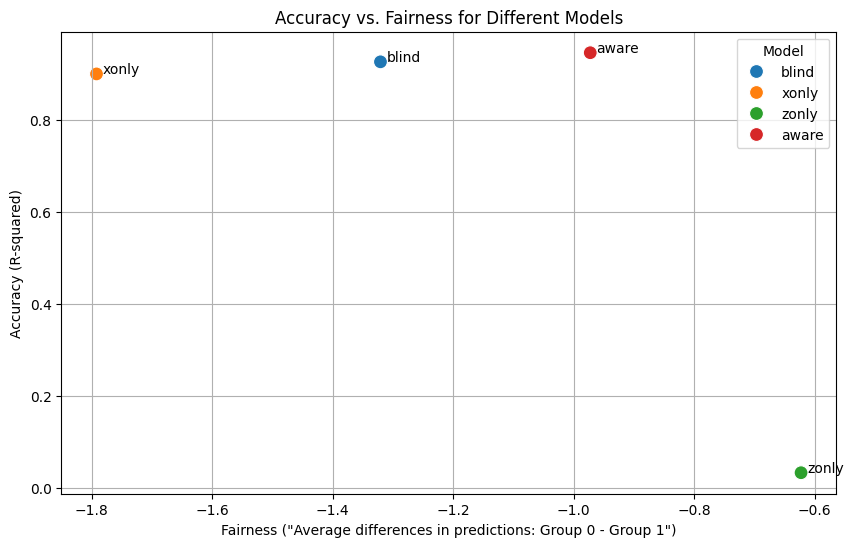

In [16]:
# Redo our plot but include the aware model
# Prepare data for plotting
models = ['blind', 'xonly', 'zonly', 'aware']
r2_values = [r2_blind, r2_xonly, r2_zonly, r2_aware]
avgpreddiff_values = [avgpreddiff_blind, avgpreddiff_xonly, avgpreddiff_zonly, avgpreddiff_aware]

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'model': models,
    'R2': r2_values,
    'Average Prediction Difference (Group 1 - Group 0)': avgpreddiff_values
})

# Plotting
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=plot_df,
    x='Average Prediction Difference (Group 1 - Group 0)',
    y='R2',
    hue='model',
    s=100 # size of markers
)

# Add labels to the points
for i in range(plot_df.shape[0]):
    plt.text(x=plot_df['Average Prediction Difference (Group 1 - Group 0)'][i] + 0.01,
             y=plot_df['R2'][i] + 0.001,
             s=plot_df['model'][i],
             fontdict=dict(color='black', size=10))

plt.title('Accuracy vs. Fairness for Different Models')
plt.xlabel('Fairness ("Average differences in predictions: Group 0 - Group 1")')
plt.ylabel('Accuracy (R-squared)')
plt.grid(True)
plt.legend(title='Model')
plt.show()


So we can see a **striking finding** -- the fully aware model is a **Pareto Improvement** on the blind model: it increases both accuracy (not surprising) and fairness (surprising). So we see here that as a modeling team we might have a dilemma in this instance because in some contexts we might not be allowed legally to use the group-aware model, since it could violate disparate treatment laws. Yet the group-aware model is arguably the clear winner and an improvement over the other cases.

## Notes on limits to model testing

For this example we have just used a simple linear model with additive terms. Since we only had two predictors, this just gave us 3 candidate models (or 4 if we count also the group-aware model). As the number of predictors increases, so would the number of candidate models. In addition, we could consider interaction terms. Very quickly we can get to a point where we would not be able to create all possible models by hand. However, this same basic approach can be done with larger groupings of variables. For example, you might train a model on all predictors and on some natural groupings or subsets of variables and explore the differences.
